<a href="https://colab.research.google.com/github/enjoyPG/2023Gifted/blob/main/students/jwoo428/last_checkpoint_basketball_football_vollyball.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/enjoyPG/2023Gifted
%cd 2023Gifted

Cloning into '2023Gifted'...
remote: Enumerating objects: 2213, done.
remote: Counting objects: 100% (472/472), done.
remote: Compressing objects: 100% (366/366), done.
remote: Total 2213 (delta 144), reused 387 (delta 101), pack-reused 1741
Receiving objects: 100% (2213/2213), 93.52 MiB | 25.97 MiB/s, done.
Resolving deltas: 100% (1004/1004), done.
/content/2023Gifted


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets

import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split

import matplotlib.pyplot as plt
import matplotlib.image as image
import numpy as np

In [3]:
transform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

transform_val = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

transform_test = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

In [4]:
train_dataset = datasets.ImageFolder(# dataset->folder->images
    root='students/jwoo428/dataset1/train_dataset',
    transform=transform_train
)
dataset_size = len(train_dataset)
train_size = int(dataset_size * 0.8)
val_size = dataset_size - train_size

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
test_dataset = datasets.ImageFolder(
    root='students/jwoo428/dataset1/test_dataset',
    transform=transform_test
)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)

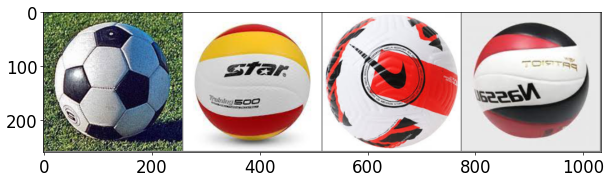

['Woman', 'Both', 'Woman', 'Both']


In [5]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})


def imshow(input):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))
    # undo image normalization
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # display images
    plt.imshow(input)
    plt.show()

    
class_names = {
  0: "Man",
  1: "Woman",
  2: "Both",
}

# load a batch of train image
iterator = iter(train_dataloader)

# visualize a batch of train image
imgs, labels = next(iterator)
out = torchvision.utils.make_grid(imgs[:4])
imshow(out)
print([class_names[labels[i].item()] for i in range(4)])

In [83]:
learning_rate = 0.007
log_step = 20
n_classes = 3 #클래스 개수

model = models.resnet50(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, n_classes) # transfer learning
model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

In [84]:
import time


def train():
    start_time = time.time()
    print(f'[Epoch: {epoch + 1} - Training]')
    model.train()
    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(train_dataloader):
        imgs, labels = batch
        imgs, labels = imgs.cuda(), labels.cuda()

        outputs = model(imgs)
        optimizer.zero_grad()
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        total += labels.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)
        
        if i % log_step == log_step - 1:
            print(f'[Batch: {i + 1}] running train loss: {running_loss / total}, running train accuracy: {running_corrects / total}')

    print(f'train loss: {running_loss / total}, accuracy: {running_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return running_loss / total, (running_corrects / total).item()


def validate():
    start_time = time.time()
    print(f'[Epoch: {epoch + 1} - Validation]')
    model.eval()
    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(val_dataloader):
        imgs, labels = batch
        imgs, labels = imgs.cuda(), labels.cuda()

        with torch.no_grad():
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        total += labels.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

        if (i == 0) or (i % log_step == log_step - 1):
            print(f'[Batch: {i + 1}] running val loss: {running_loss / total}, running val accuracy: {running_corrects / total}')

    print(f'val loss: {running_loss / total}, accuracy: {running_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return running_loss / total, (running_corrects / total).item()


def test():
    start_time = time.time()
    print(f'[Test]')
    model.eval()
    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(test_dataloader):
        imgs, labels = batch
        imgs, labels = imgs.cuda(), labels.cuda()

        with torch.no_grad():
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        total += labels.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

        if (i == 0) or (i % log_step == log_step - 1):
            print(f'[Batch: {i + 1}] running test loss: {running_loss / total}, running test accuracy: {running_corrects / total}')

    print(f'test loss: {running_loss / total}, accuracy: {running_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return running_loss / total, (running_corrects / total).item()

In [92]:
import time

def adjust_learning_rate(optimizer, epoch):
    lr = learning_rate
    if epoch >= 5:
        lr /= 10
    if epoch >= 10:
        lr /= 10
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


num_epochs = 10
best_val_acc = 0
best_epoch = 0

history = []
accuracy = []
for epoch in range(num_epochs):
    adjust_learning_rate(optimizer, epoch)
    train_loss, train_acc = train()
    val_loss, val_acc = validate()
    history.append((train_loss, val_loss))
    accuracy.append((train_acc, val_acc))

    if val_acc > best_val_acc:
        print("[Info] best validation accuracy!")
        best_val_acc = val_acc
        best_epoch = epoch
        torch.save(model.state_dict(), f'best_checkpoint_epoch_{epoch + 1}.pth')

torch.save(model.state_dict(), f'last_checkpoint.pth')

[Epoch: 1 - Training]
train loss: 0.0014852887994493357, accuracy: 1.0
elapsed time: 1.3979110717773438
[Epoch: 1 - Validation]
[Batch: 1] running val loss: 0.0052205221727490425, running val accuracy: 1.0
val loss: 0.0779482651501894, accuracy: 0.9000000357627869
elapsed time: 0.1590888500213623
[Info] best validation accuracy!
[Epoch: 2 - Training]
train loss: 0.000740268683875911, accuracy: 1.0
elapsed time: 1.3384454250335693
[Epoch: 2 - Validation]
[Batch: 1] running val loss: 0.0023370913695544004, running val accuracy: 1.0
val loss: 0.08009803472086788, accuracy: 0.9000000357627869
elapsed time: 0.1340770721435547
[Epoch: 3 - Training]
train loss: 0.00250973316578893, accuracy: 0.987500011920929
elapsed time: 1.2211616039276123
[Epoch: 3 - Validation]
[Batch: 1] running val loss: 0.023238589987158775, running val accuracy: 0.875
val loss: 0.09671673998236656, accuracy: 0.8500000238418579
elapsed time: 0.13475799560546875
[Epoch: 4 - Training]
train loss: 0.020250407815910875, ac

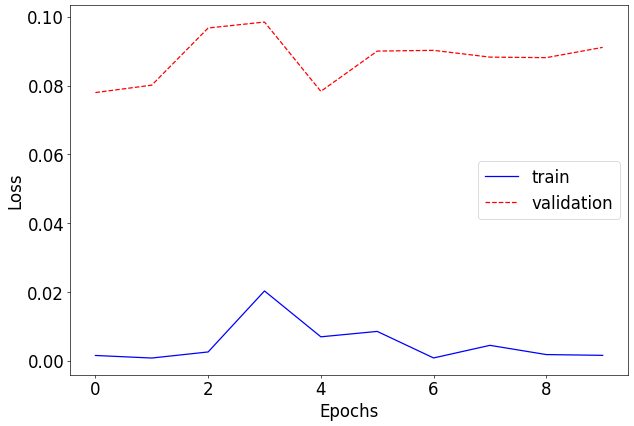

In [93]:
plt.plot([x[0] for x in history], 'b', label='train')
plt.plot([x[1] for x in history], 'r--',label='validation')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

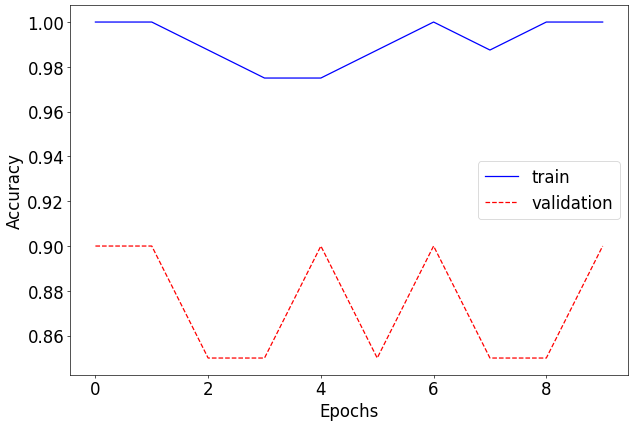

In [94]:
plt.plot([x[0] for x in accuracy], 'b', label='train')
plt.plot([x[1] for x in accuracy], 'r--',label='validation')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

In [95]:
!pwd

/content/2023Gifted


In [96]:
model = models.resnet50(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 3) # transfer learning
model = model.cuda()
model_path = 'last_checkpoint.pth'
model.load_state_dict(torch.load(model_path))

test_loss, test_accuracy = test()
print(f"Test loss: {test_loss:.8f}")
print(f"Test accuracy: {test_accuracy * 100.:.2f}%")

[Test]
[Batch: 1] running test loss: 0.15103356540203094, running test accuracy: 0.75
test loss: 0.07769684195518493, accuracy: 0.8333333730697632
elapsed time: 0.25442051887512207
Test loss: 0.07769684
Test accuracy: 83.33%


In [90]:
#last_checkpoint

#0.007 -> 83.33%
  #epoch가 20일 때보다 10일때가 손실이 더 적음
  #20 -> 0.08~~   10 -> 0.07~~


#best_checkpoint_epoch_1

#0.007 -> 93.33%      loss -> 0.03577908
#0.0069 -> 90.00%     loss -> 0.16159515
#0.0071 -> 80.00%     loss -> 0.05168268
#0.008 -> 86.67%
#0.006 -> 70.00%
#0.0075 -> 83.33%
#0.0065 -> 76.67%

# 90.00%가 가장 높게 나온 정확도 인것같음